In [5]:
# Data processing and visualizationlibrary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches
import seaborn as sns
# Tensorflow and keras library
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import load_model
# ScikitLearn library
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
# Misc
import os
import random
import sys
from unicodedata import name
from datetime import datetime
from scipy.optimize import root

print("To ensure repeatability, use the following setup:")
print("TensorFlow version:", "2.10.0")
print("Numpy version:", '1.23.4')
print("Pandas version:", '1.5.2')
print("SKLearn version:", "1.1.3")
print("Python version:", "3.8.6 (tags/v3.8.6:db45529, Sep 23 2020, 15:52:53) [MSC v.1927 64 bit (AMD64)]")
print("==============================")
print("Your current library version:")
print("TensorFlow version:", tf.__version__)
print("Numpy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("SKLearn version:", sklearn.__version__)
print("Python version:",sys.version)

To ensure repeatability, use the following setup:
TensorFlow version: 2.10.0
Numpy version: 1.23.4
Pandas version: 1.5.2
SKLearn version: 1.1.3
Python version: 3.8.6 (tags/v3.8.6:db45529, Sep 23 2020, 15:52:53) [MSC v.1927 64 bit (AMD64)]
Your current library version:
TensorFlow version: 2.10.0
Numpy version: 1.23.4
Pandas version: 1.5.2
SKLearn version: 1.1.3
Python version: 3.8.6 (tags/v3.8.6:db45529, Sep 23 2020, 15:52:53) [MSC v.1927 64 bit (AMD64)]


In [6]:
# Get the current directory
current_directory = os.getcwd()
# Construct the relative path to the CSV file
csv_filename1 = 'datasetscsv/trainval_set.csv' #Training-validation datasets
csv_filename2 = 'datasetscsv/test_set.csv' #Unseen test set
csv_filename3 = 'datasetscsv/master_dataset.csv' #Combined train-validation-test set
csv_filename4 = 'datasetscsv/allMolecule.csv' #Molecule only set
csv_path1 = os.path.join(current_directory, csv_filename1)
csv_path2 = os.path.join(current_directory, csv_filename2)
csv_path3 = os.path.join(current_directory, csv_filename3)
csv_path4 = os.path.join(current_directory, csv_filename4)
seed = 21
random.seed(seed)

model_name = 'Model/SWISH_WnD.h5'
model_path = os.path.join(current_directory, model_name)

In [65]:
# Importing 2DMA2M1P testing set from Zhang et al (2023)
df1 = pd.read_csv(csv_path4, names=["Molecule", "Formula","SMILES","Type","Cyclicity",
                                       "Primary counts","Secondary counts","Tertiary counts",
                                       "Hydroxyl counts","Carboxyl counts","Oxyl counts",
                                       "M0(nhb)", "M0(oh)", "M0(nh)", "M0(op)", 
                                       "M1(nhb_donor)", "M1(nhb_weak)", "M1(nhb_acceptor)",
                                       "M1(oh_donor)", "M1(oh_weak)","M1(oh_acceptor)",
                                       "M1(nh_donor)", "M1(nh_weak)", "M1(nh_acceptor)",
                                       "M1(op_donor)", "M1(op_weak)", "M1(op_acceptor)",
                                       "M2(nhb)", "M2(oh)", "M2(nh)","M2(op)",
                                       "MW","Partial Pressure","Temperature",
                                       "Amine Concentration", "Absorption Capacity", "References","Rounded Concentration", "Abbreviation"])

screened = df1
screened_input = screened.drop(columns=["Molecule", "Formula","SMILES","Type","Cyclicity",
                                   "Absorption Capacity","References","Rounded Concentration", "Abbreviation"])
actual_output = screened['Absorption Capacity']


concpress = df1
concpress = concpress[['Partial Pressure','Temperature', 'Rounded Concentration','Absorption Capacity']]

In [66]:
# Importing dataset for model datastructure
trainval_df = pd.read_csv(csv_path1, names=["Molecule", "Formula","SMILES","Type","Cyclicity",
                                       "Primary counts","Secondary counts","Tertiary counts",
                                       "Hydroxyl counts","Carboxyl counts","Oxyl counts",
                                       "M0(nhb)", "M0(oh)", "M0(nh)", "M0(op)", 
                                       "M1(nhb_donor)", "M1(nhb_weak)", "M1(nhb_acceptor)",
                                       "M1(oh_donor)", "M1(oh_weak)","M1(oh_acceptor)",
                                       "M1(nh_donor)", "M1(nh_weak)", "M1(nh_acceptor)",
                                       "M1(op_donor)", "M1(op_weak)", "M1(op_acceptor)",
                                       "M2(nhb)", "M2(oh)", "M2(nh)","M2(op)",
                                       "MW","Partial Pressure","Temperature",
                                       "Amine Concentration", "Absorption Capacity", "References","Rounded Concentration", "Abbreviation"]) 
test_df     = pd.read_csv(csv_path2, names=["Molecule", "Formula","SMILES","Type","Cyclicity", 
                                       "Primary counts","Secondary counts","Tertiary counts",
                                       "Hydroxyl counts","Carboxyl counts","Oxyl counts",
                                       "M0(nhb)", "M0(oh)", "M0(nh)", "M0(op)", 
                                       "M1(nhb_donor)", "M1(nhb_weak)", "M1(nhb_acceptor)",
                                       "M1(oh_donor)", "M1(oh_weak)","M1(oh_acceptor)",
                                       "M1(nh_donor)", "M1(nh_weak)", "M1(nh_acceptor)",
                                       "M1(op_donor)", "M1(op_weak)", "M1(op_acceptor)",
                                       "M2(nhb)", "M2(oh)", "M2(nh)","M2(op)",
                                       "MW","Partial Pressure","Temperature",
                                       "Amine Concentration", "Absorption Capacity", "References","Rounded Concentration", "Abbreviation"]) 
# PREPROCESSING
X_test_label = test_df.drop(columns=["Absorption Capacity"])
y_test = test_df['Absorption Capacity']

X_trainval_label =  trainval_df.drop(columns=["Absorption Capacity"])
y_trainval_label = trainval_df['Absorption Capacity']

# DATA SPLITING
X_train, X_val, y_train, y_val = train_test_split(X_trainval_label, y_trainval_label, test_size=0.20, random_state=seed)

# Reserve the dataset for visualization
X_train_1 = X_train.copy()
X_val_1 = X_val.copy()
X_reserved = pd.concat([X_train_1, X_val_1, X_test_label], axis=0)

# DROPPING STRINGS AND DATA PREPROCESSING
X_train = X_train.drop(columns=["Molecule", "Formula", "SMILES", "Type", "Cyclicity", "References", "Rounded Concentration", "Abbreviation"])
X_test = X_test_label.drop(columns=["Molecule", "Formula", "SMILES", "Type", "Cyclicity", "References", "Rounded Concentration", "Abbreviation"])
X_val = X_val.drop(columns=["Molecule", "Formula", "SMILES", "Type", "Cyclicity", "References", "Rounded Concentration", "Abbreviation"])

feature_names = X_train.columns.tolist()
preprocessor = Pipeline(steps=[('step1', StandardScaler())])
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

X_train = pipeline.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=feature_names)

X_val = pipeline.transform(X_val)
X_val = pd.DataFrame(X_val, columns=feature_names)

X_test = pipeline.transform(X_test)
X_test = pd.DataFrame(X_test, columns=feature_names)

#Overwriting dataset with master dataset
master_df = pd.read_csv(csv_path3, 
    names=["Molecule","Formula","SMILES","Type","Cyclicity",
           "Primary counts","Secondary counts","Tertiary counts",
           "Hydroxyl counts","Carboxyl counts","Oxyl counts",
           "M0(nhb)", "M0(oh)", "M0(nh)", "M0(op)", 
           "M1(nhb_donor)", "M1(nhb_weak)", "M1(nhb_acceptor)",
           "M1(oh_donor)", "M1(oh_weak)","M1(oh_acceptor)",
           "M1(nh_donor)", "M1(nh_weak)", "M1(nh_acceptor)",
           "M1(op_donor)", "M1(op_weak)", "M1(op_acceptor)",
           "M2(nhb)", "M2(oh)", "M2(nh)","M2(op)",
           "MW","Partial Pressure","Temperature",
           "Amine Concentration", "Absorption Capacity", "References","Rounded Concentration","Abbreviation"]) 

In [67]:
#WIDE-DEEP NN MODEL
model = load_model(model_path)

In [68]:
#AAD DEFINITION
def calculate_aad(y_exp, y_pred):
    aad = 0
    # Step 1: Compute the mean of the dataset
    for i in range(len(y_exp)):
        aad += sum(abs(y_exp.iloc[i]-y_pred.iloc[i])/y_exp.iloc[i])/len(y_exp)
    return aad

In [69]:
#KENT-EISENBERG MODEL
    #EQUILIBRIUM CONSTANT AND HENRY
def k1(T):
    eqCons1 = np.exp((-17.1) + (-1550 / T) + (-400 / T**2) + (0.25 / T**3) + (0.05 / T**4))
    return eqCons1
def k3(T):
    eqCons3 = np.exp((-241.818) + (298.253 * 10**3 / T) - (148.528 * 10**6 / T**2) + (332.648 * 10**8 / T**3) - (282.394 * 10**10 / T**4))
    return eqCons3
def k4(T):
    eqCons4 = np.exp((-294.74) + (364.385 * 10**3 / T) - (184.158 * 10**6 / T**2) + (415.793 * 10**8 / T**3) - (354.291 * 10**10 / T**4))
    return eqCons4
def k5(T):
    eqCons5 = np.exp((39.5554) - (987.9 * 10**2 / T) + (568.828 * 10**5 / T**2) - (146.456 * 10**8 / T**3) + (136.146 * 10**10 / T**4))
    return eqCons5
def h(T):
    henCons = np.exp((22.2819) - (138.306 * 10**2 / T) + (691.346 * 10**4 / T**2) - (155.895 * 10**7 / T**3) + (120.037 * 10**9 / T**4)) / 7.50061
    return henCons

#EQUATION TO SOLVE H+
def polynom(K1,K3,K4,K5,H,PCO2,Conc,ion):
    A   = 1
    B   = Conc+K1
    C   = -K3*PCO2/H-K5
    D   = -K1*K3* PCO2/H-K1*K5-2*K3*K4*PCO2/H
    E   = -2*K1*K3*K4*PCO2/H
    poleq = A*ion**4 + B*ion**3 + C*ion**2 + D*ion + E
    return poleq

#SOLVING CHARGE BALANCE
PCO2 = concpress['Partial Pressure']
Conc = concpress['Rounded Concentration']
K1  = k1(concpress['Temperature'])
K3  = k3(concpress['Temperature'])
K4  = k4(concpress['Temperature'])
K5  = k5(concpress['Temperature'])
H   = h (concpress['Temperature'])

# Define the function to find the root of
def polynom_to_solve(ion):
    return polynom(K1, K3, K4, K5, H, PCO2, Conc, ion)

# Make an initial guess for the root
initial_guess = np.ones(len(concpress)) * 1e-8

# Find the root using scipy.optimize.root
result = root(polynom_to_solve, initial_guess)

# Check if the root was found successfully
if result.success:
    root_ion_values = result.x
    print("Root found successfully.")
    #print(pd.DataFrame(-np.log10(root_ion_values), columns = ['pH']))
else:
    print("Root not found. Try a different initial guess or check your equations.")
alpha_pred_KE = PCO2/H/Conc*(1+K3/root_ion_values + K3*K4/root_ion_values**2)

Root found successfully.


In [70]:
#HELEI-LIU MODEL
    #EQUILIBRIUM CONSTANT AND HENRY
def k1(T, Conc):
    eqCons1 = np.exp((-29.10) + (0.0216*T) - (10.1300 / T) - (0.1750*np.log(Conc)))
    return eqCons1
def k3(T):
    eqCons3 = np.exp((-241.818) + (298.253 * 10**3 / T) - (148.528 * 10**6 / T**2) + (332.648 * 10**8 / T**3) - (282.394 * 10**10 / T**4))
    return eqCons3
def k4(T):
    eqCons4 = np.exp((-294.74) + (364.385 * 10**3 / T) - (184.158 * 10**6 / T**2) + (415.793 * 10**8 / T**3) - (354.291 * 10**10 / T**4))
    return eqCons4
def k5(T):
    eqCons5 = np.exp((39.5554) - (987.9 * 10**2 / T) + (568.828 * 10**5 / T**2) - (146.456 * 10**8 / T**3) + (136.146 * 10**10 / T**4))
    return eqCons5
def h(T):
    henCons = np.exp((22.2819) - (138.306 * 10**2 / T) + (691.346 * 10**4 / T**2) - (155.895 * 10**7 / T**3) + (120.037 * 10**9 / T**4)) / 7.50061
    return henCons

#EQUATION TO SOLVE H+
def polynom(K1,K3,K4,K5,H,PCO2,Conc,ion):
    A   = 1
    B   = Conc+K1
    C   = -K3*PCO2/H-K5
    D   = -K1*K3* PCO2/H-K1*K5-2*K3*K4*PCO2/H
    E   = -2*K1*K3*K4*PCO2/H
    poleq = A*ion**4 + B*ion**3 + C*ion**2 + D*ion + E
    return poleq

#SOLVING CHARGE BALANCE
PCO2 = concpress['Partial Pressure']
Conc = concpress['Rounded Concentration']
K1  = k1(concpress['Temperature'], Conc)
K3  = k3(concpress['Temperature'])
K4  = k4(concpress['Temperature'])
K5  = k5(concpress['Temperature'])
H   = h (concpress['Temperature'])

# Define the function to find the root of
def polynom_to_solve(ion):
    return polynom(K1, K3, K4, K5, H, PCO2, Conc, ion)

# Make an initial guess for the root
initial_guess = np.ones(len(concpress)) * 1e-8

# Find the root using scipy.optimize.root
result = root(polynom_to_solve, initial_guess)

# Check if the root was found successfully
if result.success:
    root_ion_values = result.x
    print("Root found successfully.")
    #print(pd.DataFrame(-np.log10(root_ion_values), columns = ['pH']))
else:
    print("Root not found. Try a different initial guess or check your equations.")
alpha_pred_HL = PCO2/H/Conc*(1+K3/root_ion_values + K3*K4/root_ion_values**2)

Root found successfully.


In [71]:
#Cf MODEL
    #EQUILIBRIUM CONSTANT AND HENRY

def k1(T, Conc):
    eqCons1 = np.exp((-29.10) + (0.0216*T) - (10.1300 / T) - (0.1750*np.log(Conc)))
    return eqCons1
def k3(T):
    eqCons3 = np.exp((-241.818) + (298.253 * 10**3 / T) - (148.528 * 10**6 / T**2) + (332.648 * 10**8 / T**3) - (282.394 * 10**10 / T**4))
    return eqCons3
def k4(T):
    eqCons4 = np.exp((-294.74) + (364.385 * 10**3 / T) - (184.158 * 10**6 / T**2) + (415.793 * 10**8 / T**3) - (354.291 * 10**10 / T**4))
    return eqCons4
def k5(T):
    eqCons5 = np.exp((39.5554) - (987.9 * 10**2 / T) + (568.828 * 10**5 / T**2) - (146.456 * 10**8 / T**3) + (136.146 * 10**10 / T**4))
    return eqCons5
def h(T):
    henCons = np.exp((22.2819) - (138.306 * 10**2 / T) + (691.346 * 10**4 / T**2) - (155.895 * 10**7 / T**3) + (120.037 * 10**9 / T**4)) / 7.50061
    return henCons

#EQUATION TO SOLVE H+
def polynom(K1,K3,K4,K5,H,PCO2,Conc,ion):
    A   = 1
    B   = Conc+K1
    C   = -K3*PCO2/H-K5
    D   = -K1*K3* PCO2/H-K1*K5-2*K3*K4*PCO2/H
    E   = -2*K1*K3*K4*PCO2/H
    poleq = A*ion**4 + B*ion**3 + C*ion**2 + D*ion + E
    return poleq

#SOLVING CHARGE BALANCE
PCO2 = concpress['Partial Pressure']
Conc = concpress['Rounded Concentration']
H   = h (concpress['Temperature'])
K1  = k1(concpress['Temperature'], Conc)
K3  = k3(concpress['Temperature'])
K4  = k4(concpress['Temperature'])
K5  = k5(concpress['Temperature'])


# Define the function to find the root of
def polynom_to_solve(ion):
    return polynom(K1, K3, K4, K5, H, PCO2, Conc, ion)

# Make an initial guess for the root
initial_guess = np.ones(len(concpress)) * 1e-8

# Find the root using scipy.optimize.root
result = root(polynom_to_solve, initial_guess)

# Check if the root was found successfully
if result.success:
    root_ion_values = result.x
    print("Root found successfully.")
    #print(pd.DataFrame(-np.log10(root_ion_values), columns = ['pH']))
else:
    print("Root not found. Try a different initial guess or check your equations.")

dP = (max(PCO2)-min(PCO2))/(len(PCO2)-1)    
extended_cf_model = (201.4/concpress['Temperature']) + (367.7/(PCO2 + dP)**4) - (97.93/(PCO2 + dP)**3) + (1.276/(PCO2 + dP)) - (0.0395*Conc) + (0.4022)

root_ion_values = root_ion_values*extended_cf_model
alpha_pred_Cf = PCO2/H/Conc*(1+K3/root_ion_values + K3*K4/root_ion_values**2)

Root found successfully.


2/2 [==============================] - 0s 3ms/step


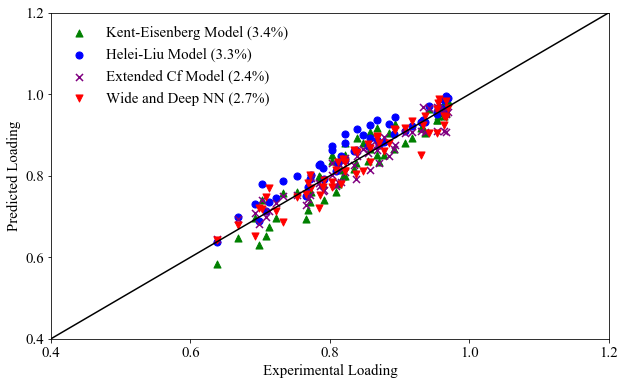

In [72]:
#MODEL OUTPUT
y_exp  = df1['Absorption Capacity']
alpha_pred_KE = alpha_pred_KE
alpha_pred_KE = pd.DataFrame(alpha_pred_KE, columns = ['Predicted loading'])

alpha_pred_HL = alpha_pred_HL
alpha_pred_HL = pd.DataFrame(alpha_pred_HL, columns = ['Predicted loading'])

alpha_pred_Cf = alpha_pred_Cf
alpha_pred_Cf = pd.DataFrame(alpha_pred_Cf, columns = ['Predicted loading'])

alpha_pred_NN = model.predict(pipeline.transform(screened_input))
alpha_pred_NN = pd.DataFrame(alpha_pred_NN, columns = ['Predicted loading'])
#MODEL OUTPUT
t1=round(calculate_aad(y_exp, alpha_pred_KE)*100, 1)
t2=round(calculate_aad(y_exp, alpha_pred_HL)*100, 1)
t3=round(calculate_aad(y_exp, alpha_pred_Cf)*100, 1)
t4=round(calculate_aad(y_exp, alpha_pred_NN)*100, 1)

plt.figure(figsize=(10, 6))
fontsize = 15
markersize = 50
csfont = {'fontname': 'Times New Roman'}
plt.scatter(y_exp,alpha_pred_KE, marker = '^', color='green', label = f"Kent-Eisenberg Model ({t1}%)", s = markersize)
plt.plot(np.array([0,2]), np.array([0,2]), color = 'black')
plt.xlabel('Experimental Loading', **csfont, fontsize = fontsize)
plt.ylabel('Predicted Loading', **csfont, fontsize = fontsize)
plt.xlim(0.4, 1)
plt.ylim(0.4, 1)
plt.xticks(np.arange(0.4, 1.3,step=0.2), fontname = 'Times New Roman', fontsize = fontsize)
plt.yticks(np.arange(0.4, 1.3,step=0.2), fontname = 'Times New Roman', fontsize = fontsize)

plt.scatter(y_exp,alpha_pred_HL, marker = 'o', color='blue', label = f"Helei-Liu Model ({t2}%)", s = markersize)
plt.xlabel('Experimental Loading', **csfont, fontsize = fontsize)
plt.ylabel('Predicted Loading', **csfont, fontsize = fontsize)
plt.xlim(0.4, 1)
plt.ylim(0.4, 1)
plt.xticks(np.arange(0.4, 1.3,step=0.2), fontname = 'Times New Roman', fontsize = fontsize)
plt.yticks(np.arange(0.4, 1.3,step=0.2), fontname = 'Times New Roman', fontsize = fontsize)

plt.scatter(y_exp, alpha_pred_Cf, marker = 'x', color='purple', label = f"Extended Cf Model ({t3}%)", s = markersize)
plt.xlabel('Experimental Loading', **csfont, fontsize = fontsize)
plt.ylabel('Predicted Loading', **csfont, fontsize = fontsize)
plt.xlim(0.4, 1)
plt.ylim(0.4, 1)
plt.xticks(np.arange(0.4, 1.3,step=0.2), fontname = 'Times New Roman', fontsize = fontsize)
plt.yticks(np.arange(0.4, 1.3,step=0.2), fontname = 'Times New Roman', fontsize = fontsize)

plt.scatter(y_exp,alpha_pred_NN, marker = 'v', color='red', label = f"Wide and Deep NN ({t4}%)", s = markersize)
plt.xlabel('Experimental Loading', **csfont, fontsize = fontsize)
plt.ylabel('Predicted Loading', **csfont, fontsize = fontsize)
plt.xlim(0.4, 1)
plt.ylim(0.4, 1)
plt.xticks(np.arange(0.4, 1.3,step=0.2), fontname = 'Times New Roman')
plt.yticks(np.arange(0.4, 1.3,step=0.2), fontname = 'Times New Roman')

legend = plt.legend(fontsize=fontsize,frameon=False)
for text in legend.get_texts():
    text.set_fontname("Times New Roman")